<a href="https://colab.research.google.com/github/ParissaAmin/Machine-Learning/blob/main/Renewable%20Energy/EnergyEfficiency_Hybrid_Model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Import necessary libraries
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVR
from xgboost import XGBRegressor
import joblib
import requests

In [ ]:
# Step 2: Download and Extract Dataset from UCI Repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
file_name = "ENB2012_data.xlsx"

In [ ]:
# Download the dataset using requests
response = requests.get(url)
open(file_name, 'wb').write(response.content)

76189

In [ ]:
# Step 3: Load dataset from the downloaded Excel file
data = pd.read_excel(file_name)

In [ ]:
# Step 4: Understand the Data
# Check the shape of the dataset
print(f"Dataset Shape: {data.shape}")
print(data.head())


Dataset Shape: (768, 10)
     X1     X2     X3      X4   X5  X6   X7  X8     Y1     Y2
0  0.98  514.5  294.0  110.25  7.0   2  0.0   0  15.55  21.33
1  0.98  514.5  294.0  110.25  7.0   3  0.0   0  15.55  21.33
2  0.98  514.5  294.0  110.25  7.0   4  0.0   0  15.55  21.33
3  0.98  514.5  294.0  110.25  7.0   5  0.0   0  15.55  21.33
4  0.90  563.5  318.5  122.50  7.0   2  0.0   0  20.84  28.28


In [ ]:
# Check for missing values
print("Missing values per column:")
print(data.isnull().sum())


Missing values per column:
X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
X7    0
X8    0
Y1    0
Y2    0
dtype: int64


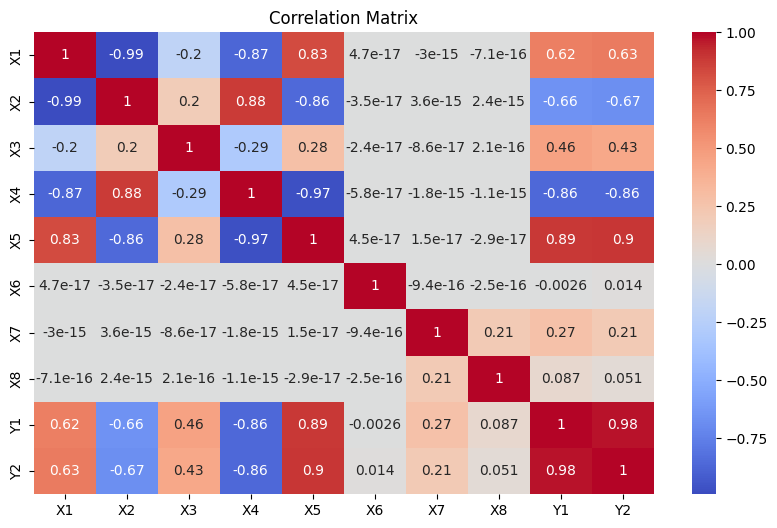

In [ ]:
# Plot the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [ ]:
# Step 5: Handle Missing Values
data.fillna(data.median(), inplace=True)

In [ ]:
# Step 6: Handle Outliers
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]

In [ ]:
# Step 7: Normalize/Scale Features
X = data[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']]  # Features
y = data['Y1']  # Target: Heating Load

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [ ]:
# Step 8: Feature Engineering
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)
X = pd.DataFrame(X_poly)

In [ ]:
# Step 9: Feature Selection
correlation_matrix = data.corr()
low_corr_features = correlation_matrix['Y1'][abs(correlation_matrix['Y1']) < 0.05].index
X = X.drop(low_corr_features, axis=1, errors='ignore')

In [ ]:
# Step 10: Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

Training set: (614, 7), Testing set: (154, 7)


# Step 11: Optimize Random Forest

Model: Random Forest (RandomForestRegressor).

Purpose: Hyperparameter tuning using GridSearchCV to find the best combination of hyperparameters for Random Forest.

Hyperparameters tuned include n_estimators, max_depth, min_samples_split, and min_samples_leaf.
Key Output: best_rf, the optimized Random Forest model.

In [ ]:

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5, verbose=2)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END m

# Step 12: Train Alternative Models (XGBoost and SVR)

Model: XGBoost (SklearnCompatibleXGB).
Purpose: Train a gradient boosting model to handle complex relationships in the data.
Uses the SklearnCompatibleXGB wrapper to ensure compatibility with scikit-learn's ensemble methods.

In [ ]:
# Step 12: Try Alternative Algorithms (XGBoost, SVR)
# Initialize XGBoost model with Sklearn compatibility wrapper
xgb_model = SklearnCompatibleXGB(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

SklearnCompatibleXGB()

# Support Vector Regression (SVR):

Model: Support Vector Regression (SVR).
Purpose: Train a non-linear regression model using the radial basis function (RBF) kernel.
Captures non-linear relationships in the data.

In [ ]:
# Initialize and fit SVR
svr_model = SVR(kernel='rbf', C=100, epsilon=0.1)
svr_model.fit(X_train, y_train)

SVR(C=100)

#Step 13: Combine Models in an Ensemble

Model: Voting Regressor (VotingRegressor).

Purpose: Combine the predictions from:

best_rf (Random Forest),
xgb_model (XGBoost),
svr_model (Support Vector Regression).
Key Mechanism:

The Voting Regressor aggregates predictions from all three models by averaging their outputs.

In [ ]:
# Step 13: Ensemble Model (assuming ensemble is defined and trained separately)
ensemble = VotingRegressor(estimators=[('rf', best_rf), ('svr', svr_model)])
ensemble.fit(X_train, y_train)


VotingRegressor(estimators=[('rf',
                             RandomForestRegressor(n_estimators=300,
                                                   random_state=42)),
                            ('svr', SVR(C=100))])

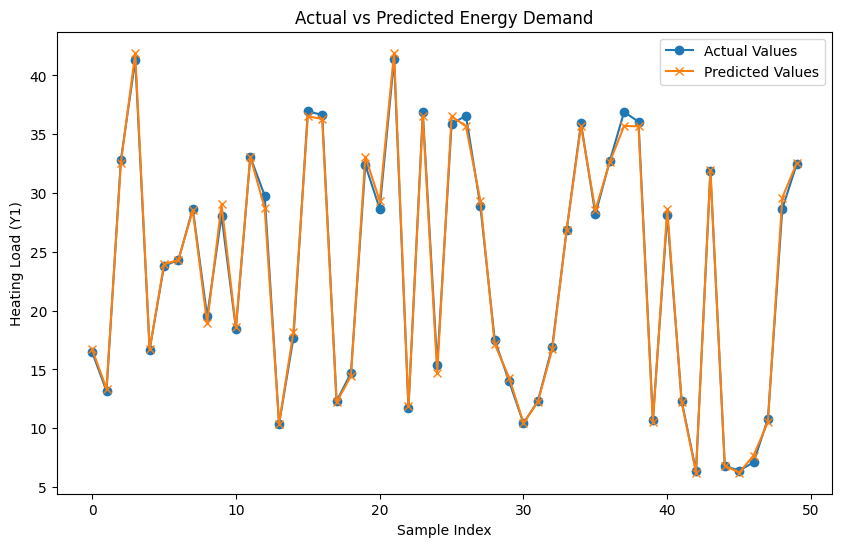

In [ ]:

# Step 15: Visualize Results
best_model = ensemble  # Ensure 'ensemble' is defined and fitted before this step
y_pred = best_model.predict(X_test)

# Plot Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:50], label="Actual Values", marker='o')
plt.plot(y_pred[:50], label="Predicted Values", marker='x')
plt.title("Actual vs Predicted Energy Demand")
plt.xlabel("Sample Index")
plt.ylabel("Heating Load (Y1)")
plt.legend()
plt.show()

Evaluate the Combined Model
The precision of the combined model (ensemble) can be assessed using common regression metrics:

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Get predictions from the ensemble model
y_pred = ensemble.predict(X_test)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Combined Model - RMSE: {rmse}")
print(f"Combined Model - MAE: {mae}")
print(f"Combined Model - R²: {r2}")


Combined Model - RMSE: 0.5339476402543459
Combined Model - MAE: 0.3790657980398826
Combined Model - R²: 0.997264765493789


Step 2: Compare Individual Models with the Ensemble
Compare the performance of the ensemble with the individual models (Random Forest, XGBoost, and SVR). This helps you understand whether combining the models improved the overall accuracy.


In [ ]:
# Evaluate each model individually
models = {
    "Random Forest": best_rf,
    "XGBoost": xgb_model,
    "SVR": svr_model,
    "Ensemble": ensemble
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} - RMSE: {rmse}, MAE: {mae}, R²: {r2}")


Random Forest - RMSE: 0.5264608640828421, MAE: 0.3577601583607626, R²: 0.9973409322175272
XGBoost - RMSE: 0.4753548093346907, MAE: 0.33070321952522574, R²: 0.9978321311354644
SVR - RMSE: 0.6012533894525316, MAE: 0.43795304585758194, R²: 0.9965317347951664
Ensemble - RMSE: 0.5339476402543459, MAE: 0.3790657980398826, R²: 0.997264765493789


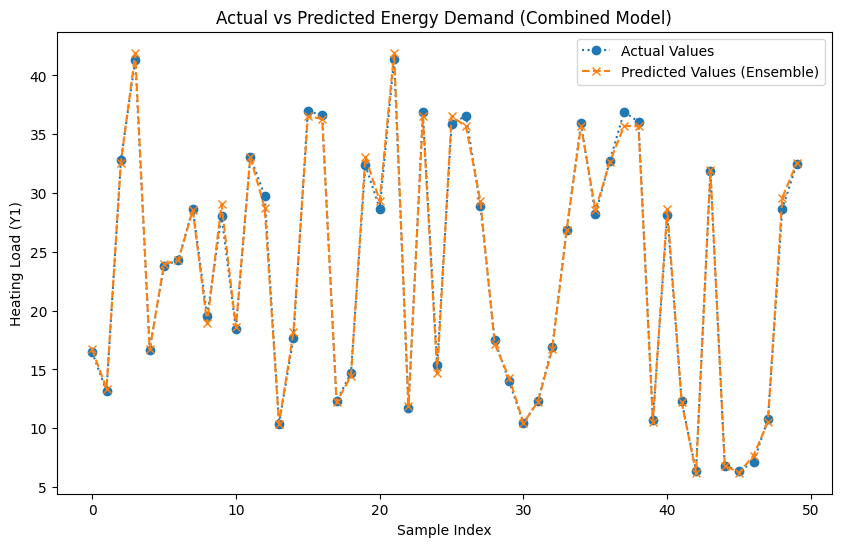

In [ ]:
import matplotlib.pyplot as plt

# Plot Actual vs Predicted values for the ensemble model
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:50], label="Actual Values", marker='o', linestyle='dotted')
plt.plot(y_pred[:50], label="Predicted Values (Ensemble)", marker='x', linestyle='dashed')
plt.title("Actual vs Predicted Energy Demand (Combined Model)")
plt.xlabel("Sample Index")
plt.ylabel("Heating Load (Y1)")
plt.legend()
plt.show()


Residual Plot:
Plot residuals (errors) to check for patterns that may indicate issues like bias or heteroscedasticity (unequal variance).

Good Residual Plot: Residuals are randomly scattered around zero.
Bad Residual Plot: Residuals show patterns or non-zero mean, indicating bias or underfitting/overfitting.


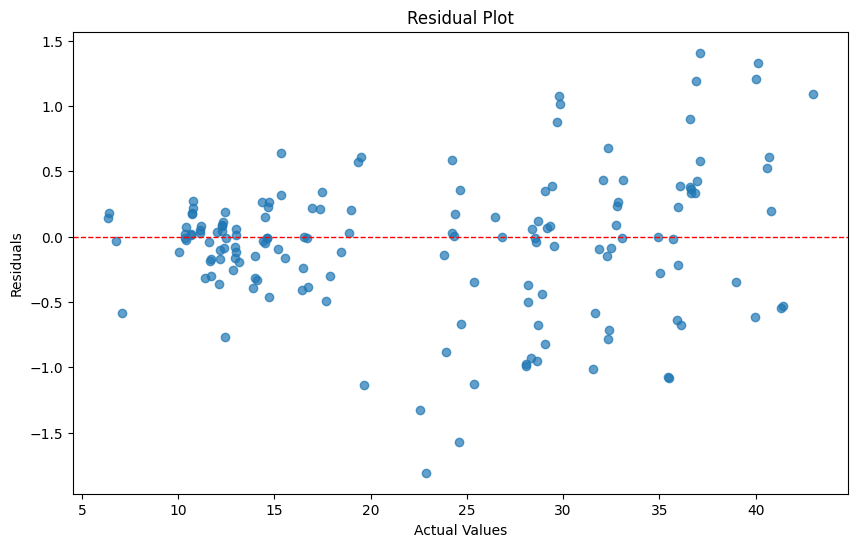

In [ ]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--', linewidth=1)
plt.title("Residual Plot")
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.show()


Cross-Validation for Robustness
Check the ensemble model’s robustness by evaluating it using cross-validation.

Code for Cross-Validation:



In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(ensemble, X, y, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-cv_scores)
print(f"Cross-validated RMSE: {rmse_scores.mean()} ± {rmse_scores.std()}")


Cross-validated RMSE: 1.2426642442149167 ± 0.8281643570743985


The cross-validated RMSE of 1.24 ± 0.83 indicates the following:

Interpretation of the Result
Mean RMSE (1.24):

On average, the ensemble model's predictions are off by about 1.24 units of the target variable (heating load, Y1).
This value is context-dependent. If the target variable values are large (e.g., 100+), an RMSE of 1.24 is excellent. However, if the target variable values are small (e.g., 1-10), it suggests room for improvement.
Standard Deviation (±0.83):

The variability of the RMSE across the 5 cross-validation folds is 0.83.
A high standard deviation relative to the mean (here ~67%) indicates variability in performance across folds, suggesting that the model may not generalize perfectly to unseen data.

Conclusion
Mean RMSE (1.24): Acceptable if the target values are large.
Standard Deviation (0.83): Indicates potential variability in the model's performance.
Focus on:

Reducing variability (±0.83) through better hyperparameter tuning or cross-validation.
Exploring why certain folds have higher errors (analyzing residuals).
Refining the ensemble structure or focusing on the strongest individual model.
These steps will help improve and better understand the ensemble model's performance. Let me know if you'd like help implementing any of these steps!

In [ ]:
# Save the best model
joblib.dump(best_model, "optimized_energy_demand_model.pkl")

['optimized_energy_demand_model.pkl']